In [ ]:
# !conda install -y catboost tensorflow

In [2]:
import os

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost.utils import get_confusion_matrix
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import shap
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from scikeras.wrappers import KerasClassifier
import xgboost as xgb

In [3]:
np.set_printoptions(suppress=True)

In [4]:
with psycopg2.connect(user='daan', password=os.environ['JUPYTER_TOKEN'], host='pg', port=5432, dbname='phishing_data') as cx:
    data = pd.read_sql_query('select * from full_dataset', cx)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [5]:
constant_features = [data.columns.get_loc(x) for x in data.nunique()[(data.nunique()==1)].index.to_list()]

In [6]:
constant_feature_names = data.columns[constant_features].to_list()

In [7]:
# drop features that are constant
data.drop(constant_feature_names, axis=1, inplace=True)

In [8]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.phishing, random_state=42)

In [10]:
cat_features = [X_train.columns.get_loc(x) for x in X_train.nunique()[(X_train.nunique()<3)].index.to_list()]

## Logistic Regression

In [11]:
cat_feature_names = X_train.columns[cat_features]
numeric_feature_names = X_train.columns.difference(cat_feature_names)

In [12]:
numeric_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist')

transform = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, [X_train.columns.get_loc(x) for x in numeric_feature_names]),
    ('categorical', cat_transformer, [X_train.columns.get_loc(x) for x in cat_feature_names])
])

In [13]:
pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [14]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [15]:
print(classification_report(pipe.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     42842
           1       0.92      0.89      0.90     23643

    accuracy                           0.93     66485
   macro avg       0.93      0.92      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [16]:
print(classification_report(pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14270
           1       0.91      0.89      0.90      7892

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



### Grid Search

In [18]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
scoring = ['accuracy', 'f1', 'roc_auc']

param_grid = {'C': np.logspace(-3, 2, 6)}

pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag'), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1))
])

In [19]:
pipe.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
The max_iter was reached which means the coef_ did not converge


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           solver='sag'),
                              n_jobs=-1,
                              param_grid={'C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [24]:
pipe.named_steps['predict'].best_params_

{'C': 100.0}

In [25]:
pipe.named_steps['predict'].cv_results_

{'mean_fit_time': array([ 1.31735606,  1.36336074,  2.46105027,  8.14203043, 21.19899731,
        95.09694552]),
 'std_fit_time': array([0.16878593, 0.10803012, 0.07371854, 0.30830971, 0.79599715,
        1.77184125]),
 'mean_score_time': array([0.01714144, 0.01288581, 0.01458287, 0.01545415, 0.01498518,
        0.01229787]),
 'std_score_time': array([0.00472041, 0.0013968 , 0.00148264, 0.0032782 , 0.00628346,
        0.00119629]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_accuracy': array([0.86026923, 0.89065203, 0.91110777, 0.92276453, 0.9269008 ,
        0.92893134]),
 'split1_test_accuracy': array([0.86184854, 0.89373543, 0.91546965, 0.92675039, 0.93058585,
        0.93111228]),
 'split2_test_accuracy': array([0.86034444, 0.892532

In [26]:
print(classification_report(pipe.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     43041
           1       0.91      0.90      0.91     23444

    accuracy                           0.93     66485
   macro avg       0.93      0.93      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [27]:
print(classification_report(pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14337
           1       0.91      0.89      0.90      7825

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



### LR with PCA

In [28]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA()),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [29]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA()),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

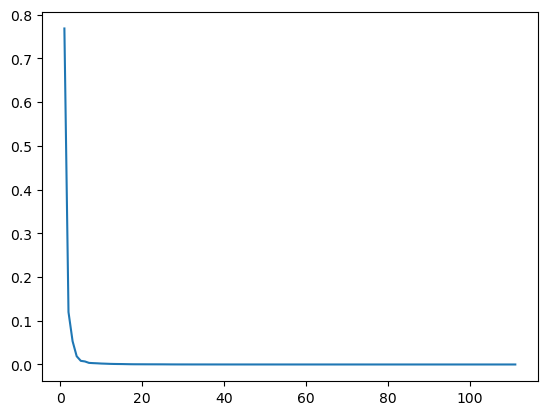

In [30]:
plt.plot((np.arange(pca_pipe.named_steps['pca'].n_components_) + 1), pca_pipe.named_steps['pca'].explained_variance_ratio_)

In [31]:
pca_pipe.named_steps['pca'].explained_variance_ratio_

array([0.76843227, 0.11987717, 0.05316217, 0.01878635, 0.00832194,
       0.00692803, 0.00365641, 0.00309916, 0.00268204, 0.00213609,
       0.00181465, 0.00144764, 0.00121476, 0.00105146, 0.00097274,
       0.00077251, 0.00060153, 0.00049256, 0.00046566, 0.00043191,
       0.00038564, 0.0003632 , 0.00034675, 0.00032576, 0.00030166,
       0.0002401 , 0.00017585, 0.00013337, 0.00011455, 0.00009964,
       0.00009714, 0.00008212, 0.00008143, 0.00007949, 0.0000763 ,
       0.00006357, 0.0000584 , 0.00004952, 0.00004568, 0.00003814,
       0.00003687, 0.00003517, 0.00003214, 0.00003162, 0.00002948,
       0.00002745, 0.00002658, 0.00002566, 0.00002356, 0.00002129,
       0.00001959, 0.00001788, 0.00001747, 0.00001423, 0.00001372,
       0.00001319, 0.00001252, 0.00001163, 0.00000982, 0.00000946,
       0.00000911, 0.00000723, 0.00000701, 0.00000525, 0.00000481,
       0.00000443, 0.00000407, 0.00000363, 0.00000349, 0.00000325,
       0.00000253, 0.00000229, 0.00000194, 0.00000119, 0.00000

In [32]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA(n_components=3)),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [33]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA(n_components=3)),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [34]:
print(classification_report(pca_pipe.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     35552
           1       0.98      0.72      0.83     30933

    accuracy                           0.86     66485
   macro avg       0.89      0.85      0.86     66485
weighted avg       0.88      0.86      0.86     66485



In [35]:
print(classification_report(pca_pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     11957
           1       0.98      0.73      0.84     10205

    accuracy                           0.87     22162
   macro avg       0.89      0.86      0.86     22162
weighted avg       0.89      0.87      0.87     22162



### Grid Search

In [36]:
pca_pipe = Pipeline(steps=[
    ('transform', transform),
    ('pca', PCA(n_components=3)),
    ('predict', GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag'), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1)) 
])

In [37]:
pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('pca', PCA(n_components=3)),
                ('predict',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           solver='sag'),
                              n_jobs=-1,
                              param_grid={'C': array([  0.001,   0.01 ,   0.1  ,   1.   ,  10.   , 100.   ])},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [38]:
pca_pipe.named_steps['predict'].best_params_

{'C': 0.001}

In [39]:
pca_pipe.named_steps['predict'].cv_results_

{'mean_fit_time': array([0.21138439, 0.22733674, 0.26956639, 0.4099308 , 0.52197866,
        0.39502687]),
 'std_fit_time': array([0.01085174, 0.04430285, 0.01476925, 0.02257141, 0.0486101 ,
        0.05949853]),
 'mean_score_time': array([0.01137071, 0.00951824, 0.00908108, 0.00963655, 0.01048675,
        0.00864301]),
 'std_score_time': array([0.00148157, 0.00127099, 0.00083978, 0.00061482, 0.00175082,
        0.00091107]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_accuracy': array([0.86026923, 0.86026923, 0.86026923, 0.86026923, 0.86026923,
        0.86026923]),
 'split1_test_accuracy': array([0.86184854, 0.86184854, 0.86184854, 0.86184854, 0.86184854,
        0.86184854]),
 'split2_test_accuracy': array([0.86034444, 0.86034444, 0.

In [40]:
print(classification_report(pca_pipe.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89     35552
           1       0.98      0.72      0.83     30933

    accuracy                           0.86     66485
   macro avg       0.89      0.85      0.86     66485
weighted avg       0.88      0.86      0.86     66485



In [41]:
print(classification_report(pca_pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     11957
           1       0.98      0.73      0.84     10205

    accuracy                           0.87     22162
   macro avg       0.89      0.86      0.86     22162
weighted avg       0.89      0.87      0.87     22162



## XGBoost

In [43]:
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html
clf = xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3)

In [44]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=3,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
print(classification_report(clf.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43597
           1       0.97      0.98      0.97     22888

    accuracy                           0.98     66485
   macro avg       0.98      0.98      0.98     66485
weighted avg       0.98      0.98      0.98     66485



In [46]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14467
           1       0.96      0.95      0.95      7695

    accuracy                           0.97     22162
   macro avg       0.97      0.96      0.96     22162
weighted avg       0.97      0.97      0.97     22162



In [47]:
clf.predict_proba(X_test.sample(1))

array([[0.9996247 , 0.00037525]], dtype=float32)

In [48]:
clf.predict_proba(X_test.sample(10))

array([[0.00009716, 0.99990284],
       [0.005885  , 0.994115  ],
       [0.9998573 , 0.00014267],
       [0.0265249 , 0.9734751 ],
       [0.01703298, 0.982967  ],
       [0.00559306, 0.99440694],
       [0.99702203, 0.00297799],
       [0.00167471, 0.9983253 ],
       [0.00007117, 0.99992883],
       [0.01861799, 0.981382  ]], dtype=float32)

In [49]:
clf.save_model('../models/xgb.json')

### Grid Search

In [50]:
param_grid = {'learning_rate': [1e-2, 5e-2, 1e-1], 'max_depth': [4, 6, 8], 'n_estimators': [100, 500, 1000]}

In [51]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1)

In [52]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_o...
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500, 1000]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc'])

In [53]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}

In [54]:
xgb_grid.cv_results_ 

{'mean_fit_time': array([ 3.92275043, 19.05516238, 32.27479506,  4.47770729, 23.39189692,
        41.0781867 ,  5.8411612 , 26.56187806, 46.28443408,  4.1842927 ,
        14.38824677, 26.98968968,  4.70398526, 17.30030751, 31.6471787 ,
         6.13143225, 20.81975417, 39.51329255,  3.70128417, 13.66222301,
        26.6621016 ,  4.47872996, 16.55103965, 35.69290833,  4.79269094,
        21.88574653, 40.85840497]),
 'std_fit_time': array([0.21322575, 1.28723206, 1.8801422 , 0.26583066, 1.01757929,
        2.44989124, 0.41345019, 0.90961811, 1.87245373, 0.2598955 ,
        0.56511409, 1.22994387, 0.2976351 , 0.71945501, 1.01650284,
        0.31724612, 1.15873515, 1.9511238 , 0.05078817, 0.60732198,
        1.12699161, 0.34532446, 0.84543808, 2.33751572, 0.12951151,
        1.07215427, 0.87539814]),
 'mean_score_time': array([0.09520688, 0.20627451, 0.37235055, 0.10496798, 0.47355795,
        0.71249018, 0.14464269, 0.66041546, 1.06606169, 0.09410477,
        0.20840764, 0.40654392, 0.115

In [55]:
print(classification_report(xgb_grid.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43514
           1       1.00      1.00      1.00     22971

    accuracy                           1.00     66485
   macro avg       1.00      1.00      1.00     66485
weighted avg       1.00      1.00      1.00     66485



In [56]:
print(classification_report(xgb_grid.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14474
           1       0.96      0.96      0.96      7688

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



## CatBoost

In [57]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [58]:
catboost_model = CatBoostClassifier(iterations=250,
                                    depth=10,
                                    learning_rate=1e-1,
                                    eval_metric='F1'
                                   )

In [59]:
catboost_model.fit(train_pool)

0:	learn: 0.8949237	total: 112ms	remaining: 27.8s
1:	learn: 0.9038120	total: 164ms	remaining: 20.4s
2:	learn: 0.9143085	total: 224ms	remaining: 18.4s
3:	learn: 0.9192387	total: 287ms	remaining: 17.7s
4:	learn: 0.9205643	total: 343ms	remaining: 16.8s
5:	learn: 0.9250478	total: 397ms	remaining: 16.1s
6:	learn: 0.9266708	total: 454ms	remaining: 15.7s
7:	learn: 0.9280310	total: 505ms	remaining: 15.3s
8:	learn: 0.9288752	total: 569ms	remaining: 15.2s
9:	learn: 0.9309655	total: 618ms	remaining: 14.8s
10:	learn: 0.9324348	total: 670ms	remaining: 14.6s
11:	learn: 0.9328625	total: 732ms	remaining: 14.5s
12:	learn: 0.9332528	total: 789ms	remaining: 14.4s
13:	learn: 0.9344283	total: 841ms	remaining: 14.2s
14:	learn: 0.9352325	total: 889ms	remaining: 13.9s
15:	learn: 0.9357556	total: 956ms	remaining: 14s
16:	learn: 0.9365847	total: 1.02s	remaining: 13.9s
17:	learn: 0.9372732	total: 1.07s	remaining: 13.8s
18:	learn: 0.9373191	total: 1.12s	remaining: 13.6s
19:	learn: 0.9384183	total: 1.17s	remaining

In [60]:
print(classification_report(y_train, catboost_model.predict(train_pool)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43504
           1       0.98      0.98      0.98     22981

    accuracy                           0.99     66485
   macro avg       0.99      0.98      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [61]:
print(classification_report(y_test, catboost_model.predict(test_pool)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14496
           1       0.96      0.96      0.96      7666

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



In [62]:
param_grid = {'iterations': [200, 250, 300], 'depth': [6, 8, 10], 'learning_rate': [1e-2, 5e-2, 1e-1]}

In [63]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search
cb_grid_model = CatBoostClassifier(eval_metric='F1', logging_level='Silent')
cb_grid_result = cb_grid_model.grid_search(param_grid, train_pool)

0:	loss: 0.9167483	best: 0.9167483 (0)	total: 2.42s	remaining: 1m 3s
1:	loss: 0.9377178	best: 0.9377178 (1)	total: 4.52s	remaining: 56.5s
2:	loss: 0.9439354	best: 0.9439354 (2)	total: 6.63s	remaining: 53.1s
3:	loss: 0.9207211	best: 0.9439354 (2)	total: 9.5s	remaining: 54.6s
4:	loss: 0.9409586	best: 0.9439354 (2)	total: 12.1s	remaining: 53.4s
5:	loss: 0.9458397	best: 0.9458397 (5)	total: 14.6s	remaining: 51.3s
6:	loss: 0.9237113	best: 0.9458397 (5)	total: 18.2s	remaining: 52.1s
7:	loss: 0.9421253	best: 0.9458397 (5)	total: 21.4s	remaining: 50.9s
8:	loss: 0.9476097	best: 0.9476097 (8)	total: 24.4s	remaining: 48.8s
9:	loss: 0.9277187	best: 0.9476097 (8)	total: 27.9s	remaining: 47.4s
10:	loss: 0.9459548	best: 0.9476097 (8)	total: 31.1s	remaining: 45.2s
11:	loss: 0.9510061	best: 0.9510061 (11)	total: 34.1s	remaining: 42.7s
12:	loss: 0.9305556	best: 0.9510061 (11)	total: 38.3s	remaining: 41.2s
13:	loss: 0.9477815	best: 0.9510061 (11)	total: 42.2s	remaining: 39.2s
14:	loss: 0.9526103	best: 0.

In [64]:
cb_grid_result['params']

{'depth': 10, 'iterations': 300, 'learning_rate': 0.1}

In [65]:
print(classification_report(y_train, cb_grid_model.predict(train_pool)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43504
           1       0.99      0.98      0.98     22981

    accuracy                           0.99     66485
   macro avg       0.99      0.99      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [66]:
print(classification_report(y_test, cb_grid_model.predict(test_pool)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14496
           1       0.96      0.96      0.96      7666

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



## Neural Network

In [67]:
# https://gist.github.com/MaxHalford/9bfaa8daf8b4bc17a7fb7ba58c880675
input_dim = len(pipe.named_steps['transform'].get_feature_names_out())
def nn_model():
    model = tf.keras.models.Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=
                  ['accuracy', 'AUC'])
    
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("tensorboard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [68]:
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', KerasClassifier(model=nn_model, batch_size=32, epochs=100,
                               validation_split=0.2, callbacks=[early_stopping, tensorboard_cb])) 
])

In [69]:
nn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 KerasClassifier(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x7efc84afe440>, <keras.callbacks.TensorBoard object at 0x7efc84afe2f0>], epochs=100, model=<function nn_model at 0x7efc84ae4e50>, validation_split=0.2))])

In [70]:
# https://www.adriangb.com/scikeras/stable/migration.html#migration
history = nn_pipe.fit(X_train, y_train)

Epoch 1/100


2022-10-14 19:01:56.391798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1663/1663 [==============================] - 3s 2ms/step - loss: 0.2280 - accuracy: 0.9075 - auc: 0.9630 - val_loss: 0.1801 - val_accuracy: 0.9201 - val_auc: 0.9803
Epoch 2/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1892 - accuracy: 0.9227 - auc: 0.9754 - val_loss: 0.1708 - val_accuracy: 0.9261 - val_auc: 0.9817
Epoch 3/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1817 - accuracy: 0.9246 - auc: 0.9774 - val_loss: 0.1588 - val_accuracy: 0.9364 - val_auc: 0.9825
Epoch 4/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1753 - accuracy: 0.9274 - auc: 0.9790 - val_loss: 0.1571 - val_accuracy: 0.9357 - val_auc: 0.9839
Epoch 5/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1705 - accuracy: 0.9302 - auc: 0.9801 - val_loss: 0.1529 - val_accuracy: 0.9390 - val_auc: 0.9849
Epoch 6/100
1663/1663 [==============================] - 3s 2ms/step - loss: 0.1664 - accuracy: 0.9314 - auc: 0.9810 - val_loss

In [71]:
print(classification_report(nn_pipe.predict(X_train), y_train))

2078/2078 [==============================] - 2s 760us/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     44388
           1       0.90      0.94      0.92     22097

    accuracy                           0.95     66485
   macro avg       0.93      0.94      0.94     66485
weighted avg       0.95      0.95      0.95     66485



In [72]:
print(classification_report(nn_pipe.predict(X_test), y_test))

693/693 [==============================] - 1s 765us/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     14794
           1       0.90      0.93      0.92      7368

    accuracy                           0.94     22162
   macro avg       0.93      0.94      0.94     22162
weighted avg       0.94      0.94      0.94     22162



In [73]:
history = nn_pipe.named_steps['predict'].history_

In [74]:
%load_ext tensorboard

In [75]:
%tensorboard --logdir=tensorboard/ --port 6006 --bind_all

### Grid Search

In [76]:
# clear session/graph
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [77]:
# https://www.adriangb.com/scikeras/stable/quickstart.html#in-an-sklearn-pipeline
# tensorboard callback doesn't work, maybe due to similar issue: https://github.com/keras-team/keras-tuner/issues/574
param_grid = {'optimizer__learning_rate': [1e-3, 1e-2, 1e-1], 'batch_size': [16, 32, 64]}
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', GridSearchCV(KerasClassifier(model=nn_model, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0), param_grid, return_train_score=True, refit='f1', scoring=scoring, n_jobs=-1))
     ])

In [78]:
nn_pipe.fit(X_train, y_train)

INFO:tensorflow:Assets written to: ram:///tmp/tmpwpmk2pab/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1s_sc4ow/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpc_833rez/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpm64qq9d2/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3oqeav57/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpi32qypwc/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp0408yfk1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp_yj_egbu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpuiclfnbt/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpiohi99we/assets


2022-10-14 19:02:52.048896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpk02ginmq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpk0v0xb0n/assets


2022-10-14 19:02:53.427710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp2520ejjw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpv5rhsxz_/assets


2022-10-14 19:02:55.320813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp40fxa1bn/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7gz5yem4/assets


2022-10-14 19:02:57.287835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpqms4ry46/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6el6fs0i/assets


2022-10-14 19:02:59.034116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpwc7td4gs/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpwev8vtjn/assets


2022-10-14 19:03:01.877687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpb48prmly/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp0agwdwfi/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmph8njobxj/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqxb03h1r/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp9p9eo9rr/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4i25k_mr/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpok93vpsg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpud8xas31/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpl_z0_47d/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4rzn4q12/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpve1ynm0a/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp82ax71pa/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpv8rlwikz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpyvlix_8p/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmprqcbagg0/assets
INFO:tensorflow:Assets wr

2022-10-14 19:11:37.069963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmp2veoqsn9/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpiv9bleg_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpbp7l9c98/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpnlaudpcu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjr5_qtca/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpjwf5jvre/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpso1iwd9t/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpgjtn705a/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpk7lpo2ji/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp4qr75r6p/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1ifqn2d1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp73kh27pg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpq35t2hrw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp78zibtr1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp6pewr5tq/assets
INFO:tensorflow:Assets wr

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 GridSearchCV(estimator=KerasClassifier(callbacks=[<keras.callbacks.EarlyStopping object at 0x7efc84afe440>], epochs=100, model=<function nn_model at 0x7efc84ae4e50>, validation_split=0.2, verbose=0),
                              n_jobs=-1,
                              param_grid={'batch_size': [16, 32, 64],
                                          'optimizer__learning_rate': [0.001,
                                                                       0.01,
                                                                       0.1]},
                              refit='f1', return_train_score=True,
                              scoring=['accuracy', 'f1', 'roc_auc']))])

In [79]:
nn_pipe.named_steps['predict'].best_params_

{'batch_size': 32, 'optimizer__learning_rate': 0.01}

In [80]:
print(classification_report(nn_pipe.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     43249
           1       0.93      0.92      0.92     23236

    accuracy                           0.95     66485
   macro avg       0.94      0.94      0.94     66485
weighted avg       0.95      0.95      0.95     66485



In [81]:
print(classification_report(nn_pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     14380
           1       0.93      0.92      0.92      7782

    accuracy                           0.95     22162
   macro avg       0.94      0.94      0.94     22162
weighted avg       0.95      0.95      0.95     22162



## SHAP Explainability

In [ ]:
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
preds = clf.predict(X_test)
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(exp.expected_value, shap_values[2,:], X_test.iloc[2,:])